In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../../')

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from sdebridge.diffusion_bridge import DiffusionBridge
from sdebridge.sde import GaussianKernelSDE
from sdebridge.utils import *
from sdebridge.plotting import *
from sdebridge.data_processing import sample_ellipse

plt.style.use('ggplot')

### Variable Q

### 2 Landmarks

In [3]:
sde_config = ConfigDict()
sde_config.dim = 4
sde_config.N = 100
sde_config.alpha = 1.0
sde_config.sigma = 0.5

sde = GaussianKernelSDE(sde_config)
bridge=DiffusionBridge(sde)

X0 = jnp.array([-0.5, 0.0, 0.5, 0.0])
XT = jnp.array([-0.5, 1.0, 0.5, 1.0])

In [4]:
forward_brownian_motion = bridge.simulate_forward_process(
    initial_val=X0,
    num_batches=16
)

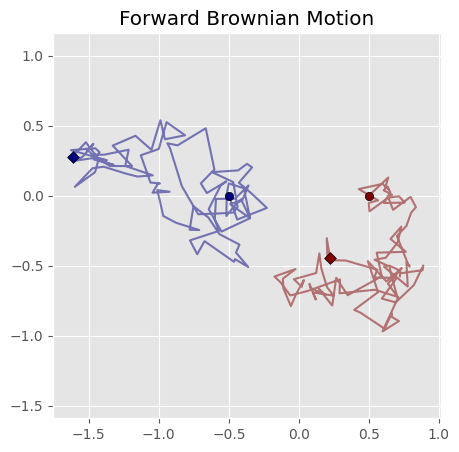

In [5]:
for i in range(1):
    plot_single_trajectory(forward_brownian_motion["trajectories"][i], title="Forward Brownian Motion")

In [13]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 64,
                "encoding_dim": 32,
                "act": 'tanh',
                "encoder_layer_dims": [32, 32],
                "decoder_layer_dims": [32, 32],
                "using_batchnorm": True},
    "training": {"batch_size": 64,
                 "num_epochs": 100,
                 "num_batches_per_epoch": 32,
                 "learning_rate": 1e-4}
}
score_p_state = bridge.learn_p_score(initial_val=X0, 
                                     setup_params=setup_params)

Training: 100%|██████████| 100/100 [00:18<00:00,  5.42epoch/s, Epoch=100, loss=4.8984]


In [14]:
score_p = Partial(lambda val, time, score_p_state: eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=X0, 
                                                           terminal_val=XT,
                                                           score_p=score_p,
                                                           num_batches=4)

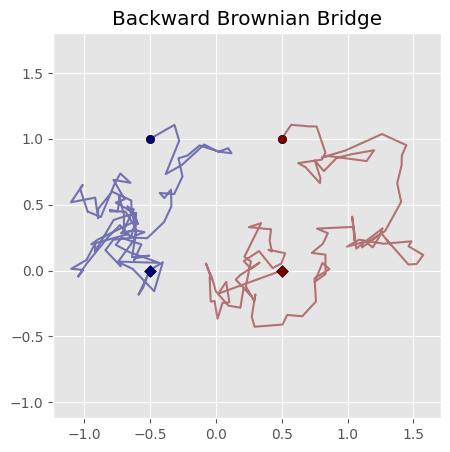

In [17]:
for i in range(1):
    plot_single_trajectory(backward_brownian_bridge["trajectories"][i], title="Backward Brownian Bridge")

In [18]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 64,
                "encoding_dim": 32,
                "act": 'tanh',
                "encoder_layer_dims": [32, 32],
                "decoder_layer_dims": [32, 32],
                "using_batchnorm": True},
    "training": {"batch_size": 64,
                 "num_epochs": 100,
                 "num_batches_per_epoch": 32,
                 "learning_rate": 1e-4}
}
score_p_star_state = bridge.learn_p_star_score(initial_val=X0,
                                               terminal_val=XT,
                                               score_p=score_p,
                                               setup_params=setup_params)

Training: 100%|██████████| 100/100 [00:24<00:00,  4.07epoch/s, Epoch=100, loss=4.8080]


In [19]:
score_h = Partial(lambda val, time, score_p_state, score_p_star_state: eval_score(state=score_p_star_state, val=val, time=time) - eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state, score_p_star_state=score_p_star_state)
forward_brownian_bridge = bridge.simulate_forward_bridge(initial_val=X0,
                                                         terminal_val=XT,
                                                         score_h=score_h,
                                                         num_batches=4)

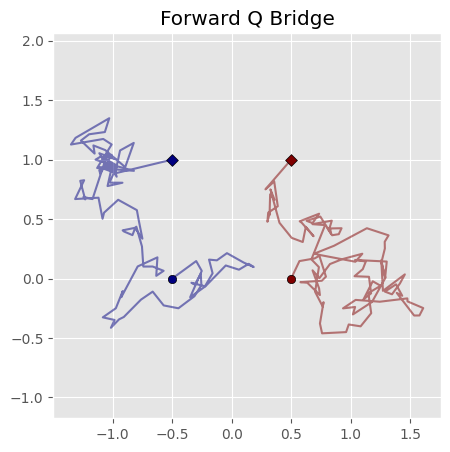

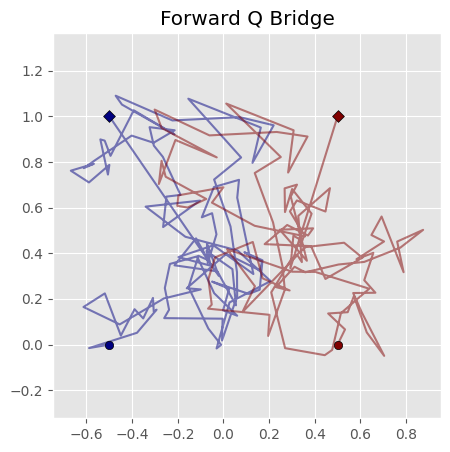

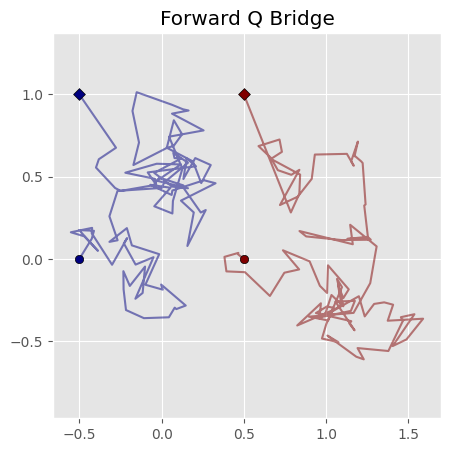

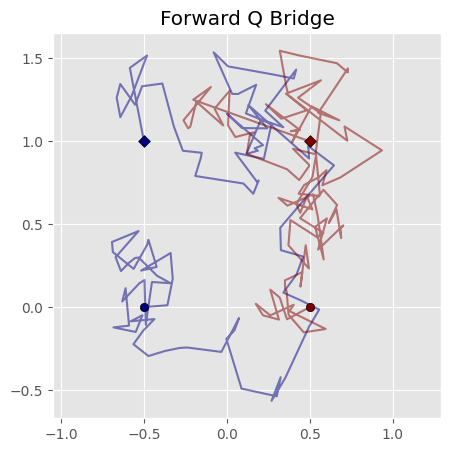

In [20]:
for i in range(4):
    plot_single_trajectory(forward_brownian_bridge["trajectories"][i], title="Forward Q Bridge")

### 4 Landmarks

In [3]:
sde_config = ConfigDict()
sde_config.dim = 8
sde_config.N = 100
sde_config.alpha = 0.5
sde_config.sigma = 0.5

sde = GaussianKernelSDE(sde_config)
bridge=DiffusionBridge(sde)

X0 = jnp.array([-0.5, 0.0, 0.5, 0.0, 0.5, 1.0, -0.5, 1.0])
XT = jnp.array([-0.5, 1.0, 0.5, 1.0, 0.5, 2.0, -0.5, 2.0])

In [4]:
forward_brownian_motion = bridge.simulate_forward_process(
    initial_val=X0,
    num_batches=1
)

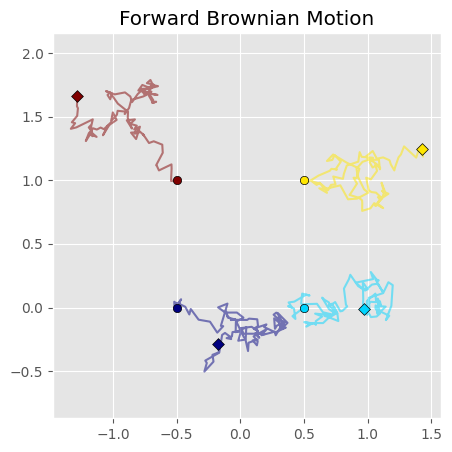

In [5]:
for i in range(1):
    plot_single_trajectory(forward_brownian_motion["trajectories"][i], title="Forward Brownian Motion")

In [7]:
setup_params = {
    "network": {"output_dim": sde.dim,
                "time_embedding_dim": 32,
                "encoding_dim": 32,
                "act_fn": 'tanh',
                "x_encoder_layer_dims": [32, 32],
                "t_encoder_layer_dims": [32, 32],
                "decoder_layer_dims": [128, 128],
                "batchnorm": True,
                "dropout_prob": 0.2},
    "training": {"batch_size": 64,
                 "num_epochs": 100,
                 "num_batches_per_epoch": 32,
                 "learning_rate": 1e-3}
}
score_p_state = bridge.learn_p_score(initial_val=X0, 
                                     setup_params=setup_params)

Training: 100%|██████████| 100/100 [01:47<00:00,  1.07s/epoch, Epoch=100, loss=40.6575]


In [8]:
score_p = partial(lambda val, time, score_p_state: eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=X0, 
                                                           terminal_val=XT,
                                                           score_p=score_p,
                                                           num_batches=4)

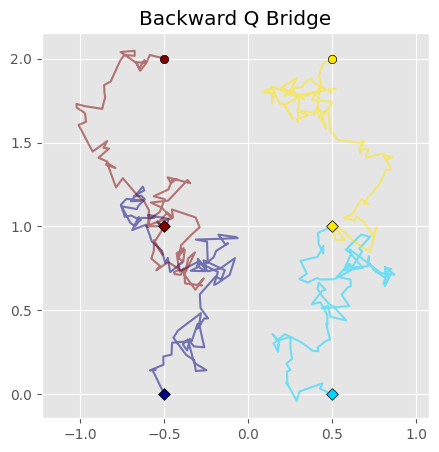

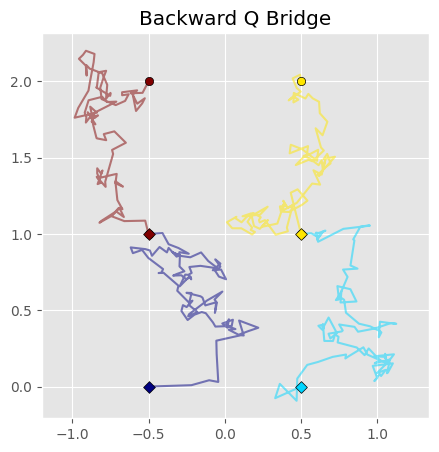

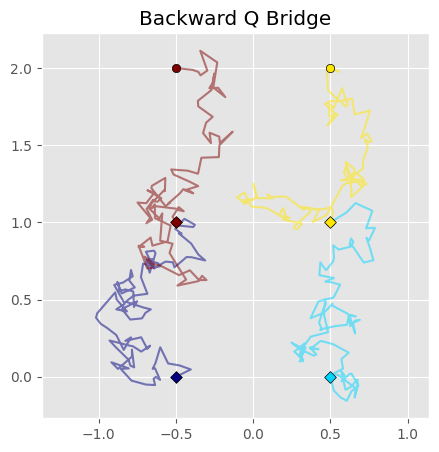

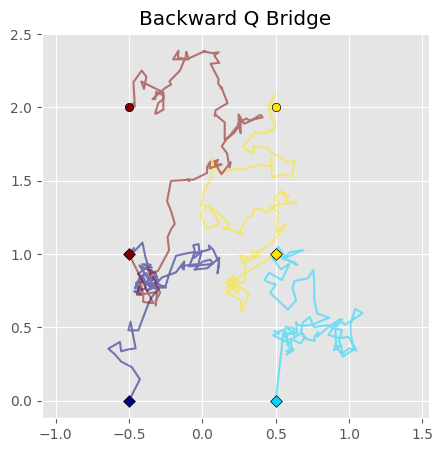

In [9]:
for i in range(4):
    plot_single_trajectory(backward_brownian_bridge["trajectories"][i], title="Backward Q Bridge")

In [11]:
setup_params = {
    "network": {"output_dim": sde.dim,
                "time_embedding_dim": 32,
                "encoding_dim": 32,
                "act_fn": 'tanh',
                "x_encoder_layer_dims": [32, 32],
                "t_encoder_layer_dims": [32, 32],
                "decoder_layer_dims": [128, 128],
                "batchnorm": True,
                "dropout_prob": 0.2},
    "training": {"batch_size": 64,
                 "num_epochs": 100,
                 "num_batches_per_epoch": 32,
                 "learning_rate": 1e-3}
}
score_p_star_state = bridge.learn_p_star_score(initial_val=X0,
                                               terminal_val=XT,
                                               score_p=score_p,
                                               setup_params=setup_params)

Training: 100%|██████████| 100/100 [02:45<00:00,  1.66s/epoch, Epoch=100, loss=40.6716]


In [12]:
score_h = partial(lambda val, time, score_p_state, score_p_star_state: eval_score(state=score_p_star_state, val=val, time=time) - eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state, score_p_star_state=score_p_star_state)
forward_brownian_bridge = bridge.simulate_forward_bridge(initial_val=X0,
                                                         terminal_val=XT,
                                                         score_h=score_h,
                                                         num_batches=4)

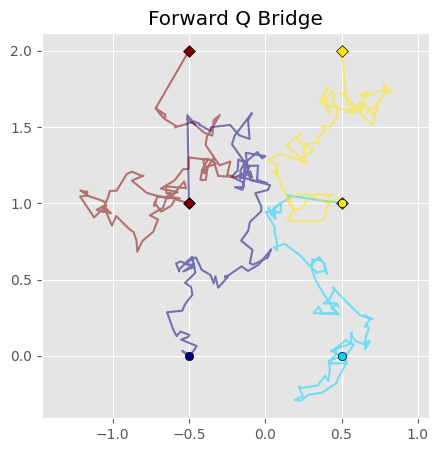

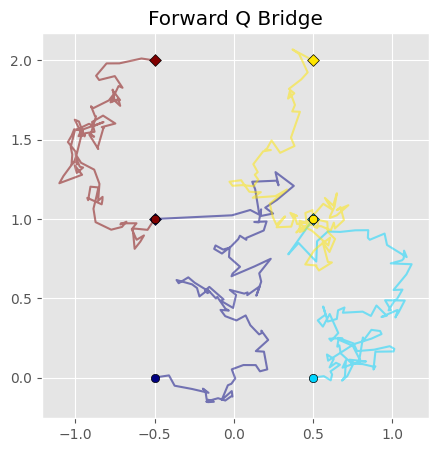

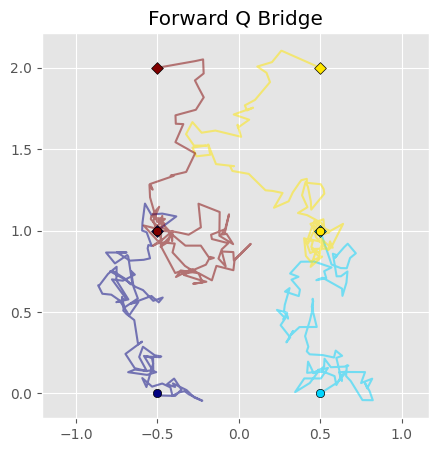

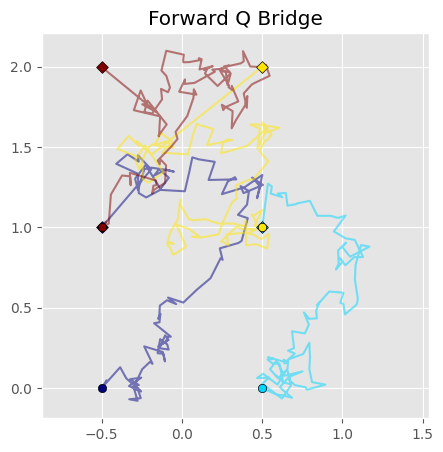

In [13]:
for i in range(4):
    plot_single_trajectory(forward_brownian_bridge["trajectories"][i], title="Forward Q Bridge")

### 8 Landmarks

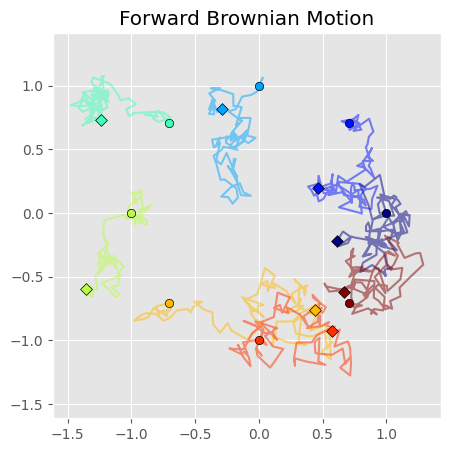

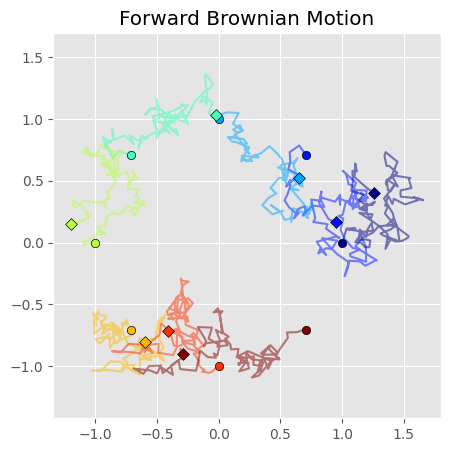

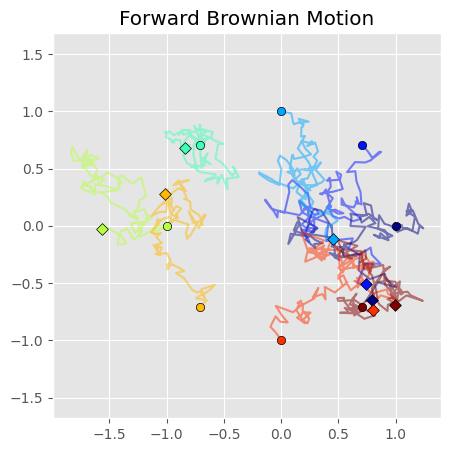

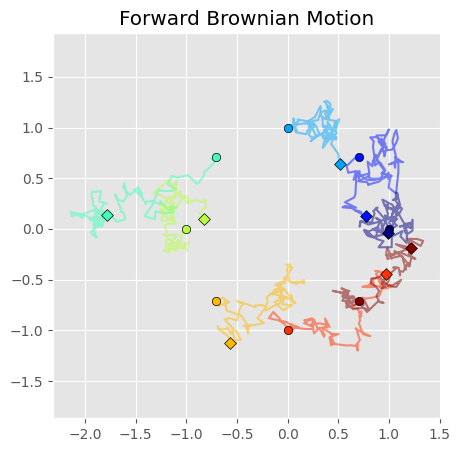

In [7]:
sde_config = ConfigDict()
sde_config.dim = 16
sde_config.N = 100
sde_config.T = 1.0
sde_config.alpha = 0.5
sde_config.sigma = 0.5

sde = GaussianKernelSDE(sde_config)
bridge = DiffusionBridge(sde)

X0 = sample_ellipse(num_points=sde_config.dim//2, scale=1.0).flatten()
XT = sample_ellipse(num_points=sde_config.dim//2, scale=1.5).flatten()
forward_brownian_motion = bridge.simulate_forward_process(
    initial_val=X0,
    num_batches=4
)

for i in range(4):
    plot_single_trajectory(forward_brownian_motion["trajectories"][i], title="Forward Brownian Motion")

In [8]:
setup_params = {
    "network": {"output_dim": sde.dim,
                "time_embedding_dim": 32,
                "encoding_dim": 32,
                "act_fn": 'elu',
                "x_encoder_layer_dims": [32],
                "t_encoder_layer_dims": [32],
                "decoder_layer_dims": [128, 64],
                "batchnorm": True,
                "dropout_prob": 0.0},
    "training": {"batch_size": 64,
                 "num_epochs": 100,
                 "num_batches_per_epoch": 100,
                 "learning_rate": 1e-3,
                 "warmup_steps": 500}
}
score_p_state = bridge.learn_p_score(initial_val=X0, 
                                     setup_params=setup_params)

Training: 100%|██████████| 100/100 [21:26<00:00, 12.87s/epoch, Epoch=100, loss=85.1687]


In [9]:
score_p = partial(lambda val, time, score_p_state: eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=X0, 
                                                           terminal_val=XT,
                                                           score_p=score_p,
                                                           num_batches=4)

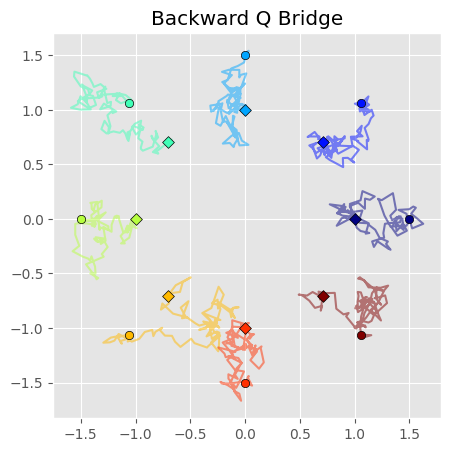

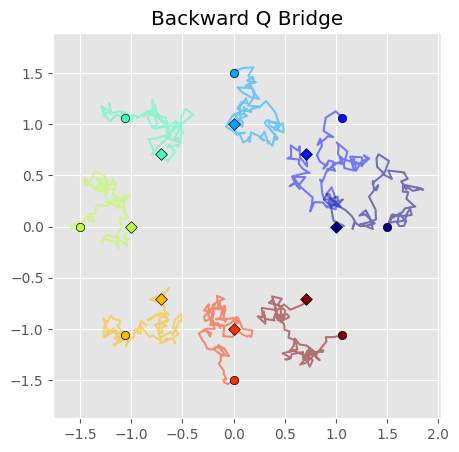

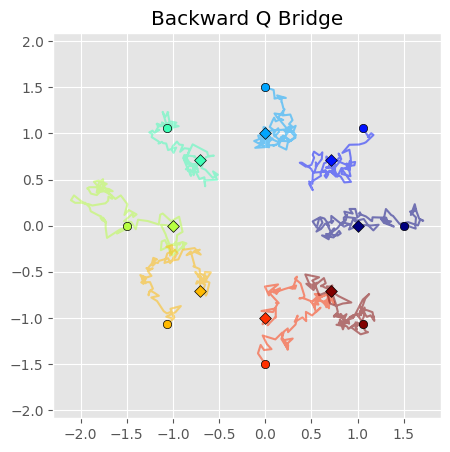

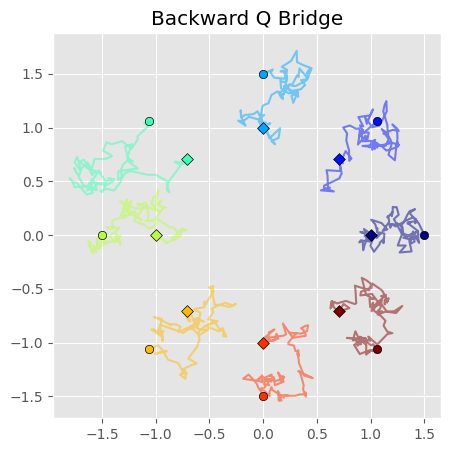

In [10]:
for i in range(4):
    plot_single_trajectory(backward_brownian_bridge["trajectories"][i], title="Backward Q Bridge")

In [12]:
setup_params = {
    "network": {"output_dim": sde.dim,
                "time_embedding_dim": 32,
                "encoding_dim": 32,
                "act_fn": 'elu',
                "x_encoder_layer_dims": [32, 32],
                "t_encoder_layer_dims": [32, 32],
                "decoder_layer_dims": [128, 64],
                "batchnorm": True,
                "dropout_prob": 0.0},
    "training": {"batch_size": 64,
                 "num_epochs": 100,
                 "num_batches_per_epoch": 100,
                 "learning_rate": 1e-3,
                 "warmup_steps": 500}
}
score_p_star_state = bridge.learn_p_star_score(initial_val=X0,
                                               terminal_val=XT,
                                               score_p=score_p,
                                               setup_params=setup_params)

Training: 100%|██████████| 100/100 [26:39<00:00, 15.99s/epoch, Epoch=100, loss=77.8873]


In [13]:
score_h = partial(lambda val, time, score_p_state, score_p_star_state: eval_score(state=score_p_star_state, val=val, time=time) - eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state, score_p_star_state=score_p_star_state)
forward_brownian_bridge = bridge.simulate_forward_bridge(initial_val=X0,
                                                         terminal_val=XT,
                                                         score_h=score_h,
                                                         num_batches=4)

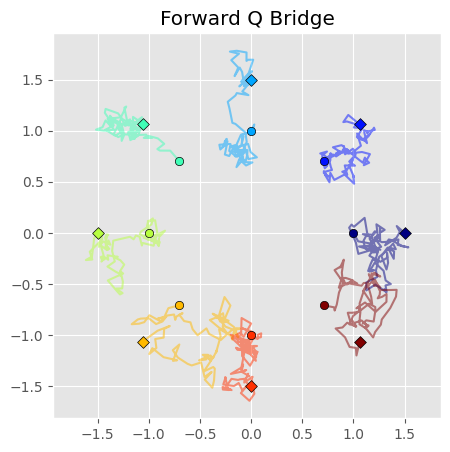

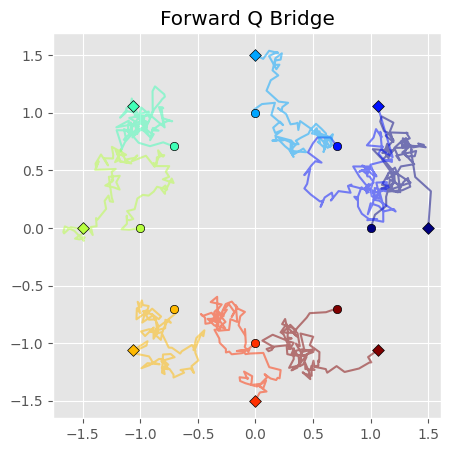

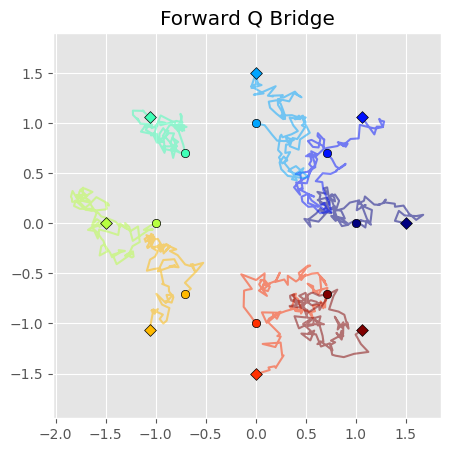

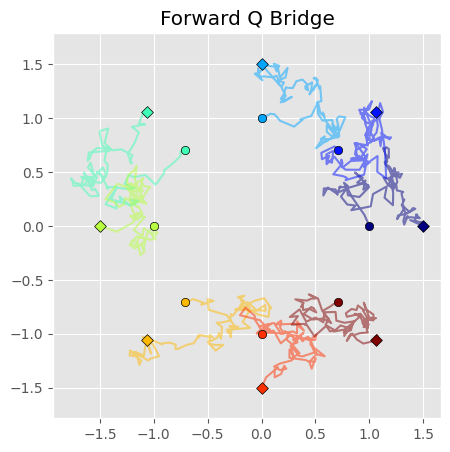

In [14]:
for i in range(4):
    plot_single_trajectory(forward_brownian_bridge["trajectories"][i], title="Forward Q Bridge")

### 16 Landmarks

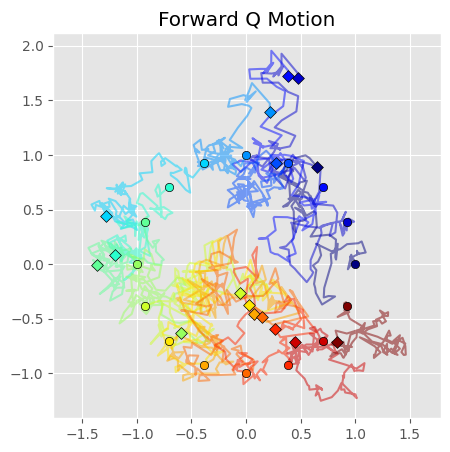

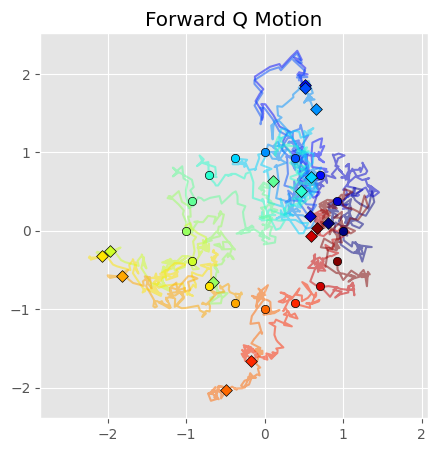

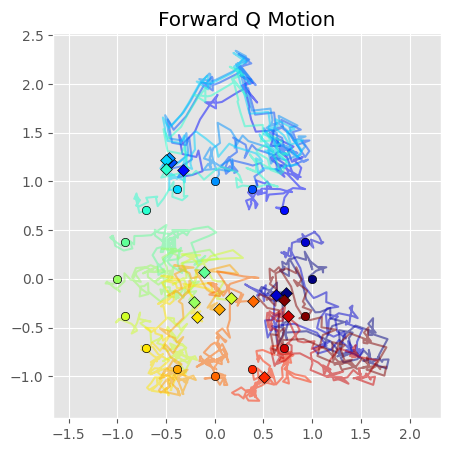

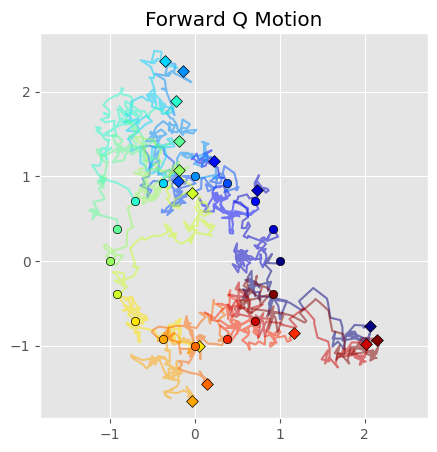

In [8]:
# d = 32
# alpha = 1.0
# sigma = 0.01
# sde_params = {
#     "dimension": d,
#     "num_steps": 100,
#     "alpha": alpha,
#     "sigma": sigma,
# }

sde_config = ConfigDict()
sde_config.dim = 32
sde_config.N = 100
sde_config.T = 1.0
sde_config.alpha = 0.5
sde_config.sigma = 0.5

sde = GaussianKernelSDE(sde_config)
bridge = DiffusionBridge(sde)

X0 = sample_ellipse(num_points=sde_config.dim//2, scale=1.0)
XT = sample_ellipse(num_points=sde_config.dim//2, scale=2.0)
forward_brownian_motion = bridge.simulate_forward_process(
    initial_val=X0,
    num_batches=4
)

for i in range(4):
    plot_single_trajectory(forward_brownian_motion["trajectories"][i], title="Forward Q Motion")

In [9]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 64,
                "encoding_dim": 64,
                "act": 'gelu',
                "encoder_layer_dims": [64, 64],
                "decoder_layer_dims": [64, 64],
                "using_batchnorm": True},
    "training": {"batch_size": 8,
                 "num_epochs": 50,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 2e-4}
}
score_p_state = bridge.learn_p_score(initial_val=X0, 
                                     setup_params=setup_params,
                                     rng_key=rng_key,
                                     )

Training: 100%|██████████| 50/50 [01:17<00:00,  1.56s/epoch, Epoch=50, loss=15.4760]


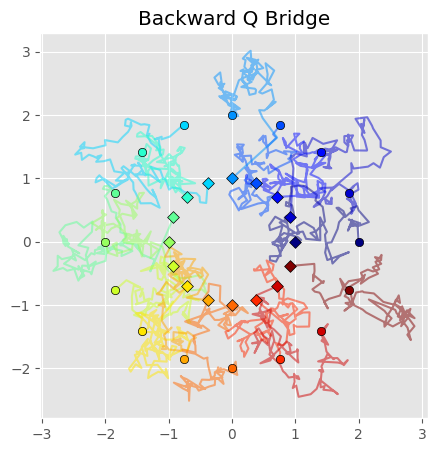

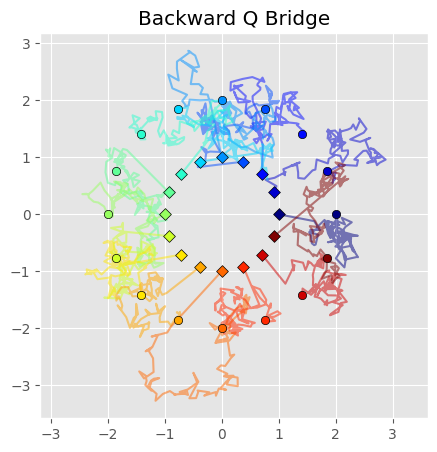

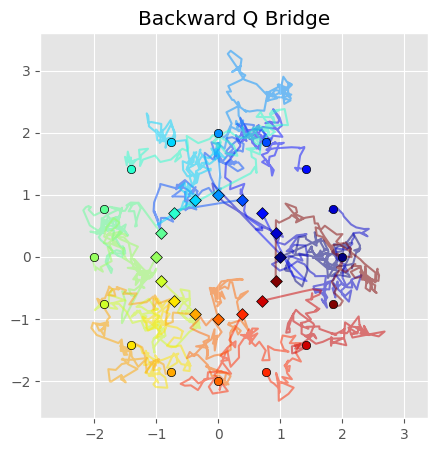

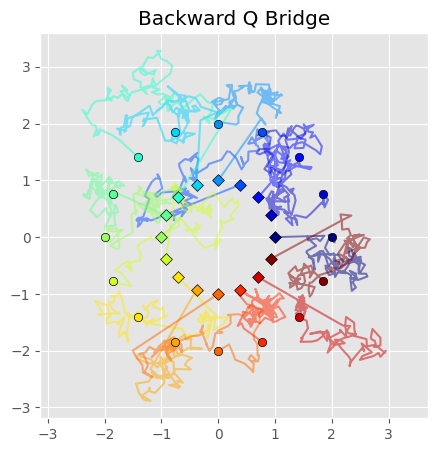

In [14]:
score_p = Partial(lambda val, time, score_p_state: eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=X0, 
                                                           terminal_val=XT,
                                                           score_p=score_p,
                                                           rng_key=rng_key,
                                                           num_batches=4)
for i in range(4):
    plot_single_trajectory(backward_brownian_bridge["trajectories"][i], title="Backward Q Bridge")